# Computing the oceanic kinetic energy flux across spatial scales using coarse-graining
by René Schubert and Willi Rath\
GEOMAR Helmholtz-Centre for Ocean Research Kiel\
rschubert@geomar.de

## Introduction
Following Leonard (1975) and Germano (1992), the flux of kinetic energy from currents associated with horizontal scales larger than a particular horizontal length scale $L$ to currents associated with scales smaller than $L$ is defined as:

$\Pi = -\rho_0[(\overline{u^2}-\overline{u}^2) \overline{u}_x + (\overline{uv}-\overline{u}\text{ }\overline{v})(\overline{u}_y + \overline{v}_x) + (\overline{v^2}-\overline{v}^2) \overline{v}_y]$ 

Here, $\rho$ is the standard density, $u$ the zonal and $v$ the meridional velocity component, $x$ the zonal and $y$ the meridional Cartesian distance. Derivatives of $a$ with respect to $b$ are writtes as $\frac{\partial a}{\partial b} = a_b$. Overbars denote convolutions with a convolution kernel and thus low-pass filtered fields.

Here we follow Aluie et al. (2018) and use a top-hat convolution kernel consisting of a circular area of diameter $L$ with the value of the inverse of the circle's area and 0 elsewhere (The integral of the convolution kernel is 1). We compute $\Pi$ with two different variants. First, on the geographical grid and second on a metric grid, where $u$ and $v$ first have to be interpolated onto. The latter variant showed a better performance with respect to computational time and memory demand for large areas or large $L$. In particular, if the computations shall be executed for a range of scales $L$, saving the interpolated data and applying the analysis for each $L$ to it, is associated with a performance gain compared to the first variant (but also with the respective high storage demands). 

## 1. Load some 2D-fields of $u$ and $v$ and interpolate them onto the same grid (if necessary) 
Here, we use exemplary a model snapshot of the 1/60° horizontal resolution NEMO simulation INALT60 (Schwarzkopf et al., 2019, Schubert et al., 2020).
INALT60 solves the primitive equations on a Arakawa C-Grid (Arakawa & Lamb, 1977) with geographical coordinates. The u-values are computed on the center of the eastern boundary of the grid cell (U-grid points) and the v-values on the center of the northern boundary (V-grid points).
For the computation of the scale kinetic energy flux, it is necessary to interpolate both fields onto the same grid at some point.
Here, we decide to perform this interpolation at the beginning and choose to interpolate both fields onto the centre of the grid cell (T-grid point).

In [1]:
# load necessary modules
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ia,ib,ja,jb = 100,601,600,1101 # chose region

# load u and v and interpolate them onto the T-grid points
path = '/gxfs_home/geomar/smomw244/_HLRN/SDIR/INALT60.L120/INALT60.L120-KRS0020-S/'
ds = xr.open_dataset(path+'2_INALT60.L120-KRS0020_5d_20130625_20130719_grid_U.nc')
u_org = ds.vozocrtx.isel(depthu=0,time_counter=0,x=slice(ia,ib),y=slice(ja,jb)).squeeze()
u = (u_org.shift(x=1)+u_org)/2 # interpolation onto T-grid points

ds = xr.open_dataset(path+'2_INALT60.L120-KRS0020_5d_20130625_20130719_grid_V.nc')
v_org = ds.vomecrty.isel(depthv=0,time_counter=0,x=slice(ia,ib),y=slice(ja,jb)).squeeze()
latv = v_org.nav_lat
lonv = v_org.nav_lon
v = (v_org.shift(y=1)+v_org)/2 # interpolation onto T-grid points

# load coordinates of T-grid-points
lat = u_org.nav_lat
lon = v_org.nav_lon

# cut first row and first column, as the interpolation gives no values there  
u = u.isel(x=slice(1,None),y=slice(1,None))
v = v.isel(x=slice(1,None),y=slice(1,None))
lon = lon.isel(x=slice(1,None),y=slice(1,None))
lat = lat.isel(x=slice(1,None),y=slice(1,None))

/gxfs_home/geomar/smomw244/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


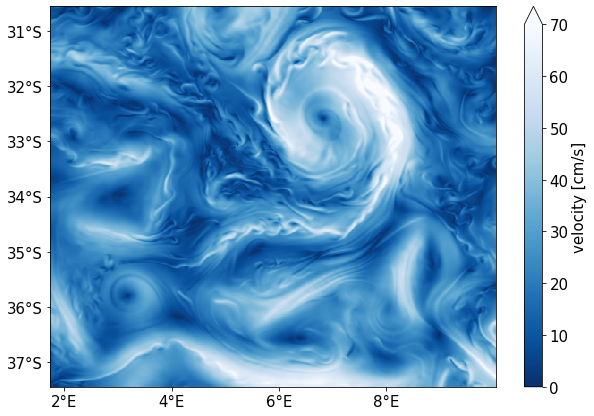

In [3]:
# show the velocity for the example data
vel = (u**2+v**2)**0.5 # compute the velocity
plt.figure(figsize=(10,7))
# define geographical ticks for the plots
def addplot():
    plt.xticks([2,4,6,8],['2°E','4°E','6°E','8°E'],fontsize=15)
    plt.yticks([-37,-36,-35,-34,-33,-32,-31],['37°S','36°S','35°S','34°S','33°S','32°S','31°S'],fontsize=15)
    
cp = plt.pcolormesh(lon,lat,100*vel,cmap='Blues_r',vmin=0,vmax=70)
cbar = plt.colorbar(cp,shrink=1,extend='max')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'velocity [cm/s]', fontsize = 15)
addplot()

A velocity snapshot from INALT60 showing submesoscale flows around an Agulhas ring.

## 2. Compute the Scale Kinetic Energy Flux $\Pi$
First, choose the horizontal length scale $L$, for which you like to compute the flux through.\
$L$ equals the diameter of the non-zero convolution kernel.

In [4]:
scale = 50 # in km

### 2.1 Variant 1: On the Geographical Grid
For this variant you need to know the grid spacing (gs) in kilometer. 
You can compute that from the geographical coordinates using for example the Haversine formula. However, for most models, you can load the grid-spacing directly from the mask file.

In [5]:
%%time
ds = xr.open_dataset('/gxfs_home/geomar/smomw244/_HLRN/INALT/MASKS/INALT60.L120-KRS0020/2_mesh_mask.nc')
e1t = ds.e1t.isel(x=slice(ia+1,ib),y=slice(ja+1,jb)).squeeze() # load zonal extend of the grid-cell in m
e2t = ds.e2t.isel(x=slice(ia+1,ib),y=slice(ja+1,jb)).squeeze() # load meridional extend of the grid-cell in m
gs = e1t / 1000 # note that e1t and e2t are equal and convert into km

# Now convolute the fields with a top-hat kernel, whichs diameter equals the chosen length scale.
radius = int( (scale / gs.min().compute() / 2 ).round()) # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing  
window_size = 2 * radius + 1
gsr = gs.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
gsr_lat = gsr.cumsum("lat_window")
gsr_lat -= gsr_lat.isel(lat_window=radius)
gsr_lon = gsr.cumsum("lon_window")
gsr_lon -= gsr_lon.isel(lon_window=radius)
circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < scale / 2)
Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])

# convolute u
uA  = gs ** 2 * u # multiplication with area
uAr = uA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
um = ((uAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)

# convolute v
vA  = gs ** 2 * v # multiplication with area
vAr = vA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
vm = ((vAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)

# convolute u²
uuA  = gs ** 2 * u * u # multiplication with area
uuAr = uuA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
uum = ((uuAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)

# convolute v²
vvA  = gs ** 2 * v * v # multiplication with area
vvAr = vvA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
vvm = ((vvAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)

# convolute uv
uvA  = gs ** 2 * u * v # multiplication with area
uvAr = uvA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
uvm = ((uvAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)


# compute the horizontal derivatives of um and vm (using centred difference)
dumdx = (um.shift(x=-1) - um.shift(x=1)) / ((gs + gs.shift(x=-1) / 2 + gs.shift(x=1) / 2) * 1000) # grid spacing converted into m
dumdy = (um.shift(y=-1) - um.shift(y=1)) / ((gs + gs.shift(y=-1) / 2 + gs.shift(y=1) / 2) * 1000)
dvmdx = (vm.shift(x=-1) - vm.shift(x=1)) / ((gs + gs.shift(x=-1) / 2 + gs.shift(x=1) / 2) * 1000)
dvmdy = (vm.shift(y=-1) - vm.shift(y=1)) / ((gs + gs.shift(y=-1) / 2 + gs.shift(y=1) / 2) * 1000)

# compute the scale kinetic energy flux
rho_0 = 1024 # define standard density in kg/m³
pi = -1 * rho_0 * ((uum - um ** 2) * dumdx + (uvm - um * vm) * (dumdy + dvmdy) + (vvm - vm ** 2) * dvmdy)

CPU times: user 17.3 s, sys: 10.6 s, total: 27.8 s
Wall time: 28 s


/gxfs_home/geomar/smomw244/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
/gxfs_home/geomar/smomw244/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/gxfs_home/geomar/smomw244/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:24: Mat

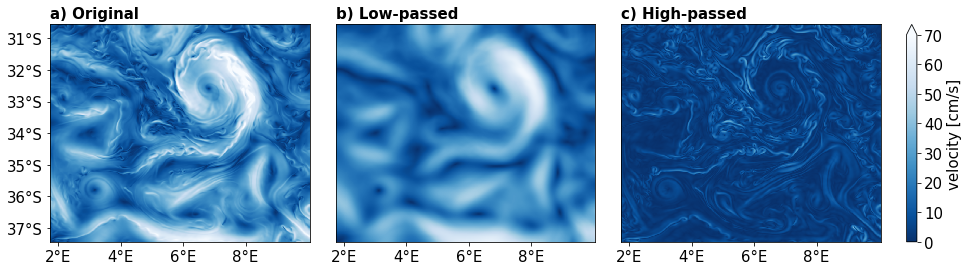

In [6]:
# show the velocity for the original, the low- and the high-passed fields
plt.figure(figsize=(20,4))
gc=plt.GridSpec(1,4) # rows, columns
gc.update(wspace=0.1, hspace=0.1)

# the velocity from the original components
vel = ( u ** 2 + v ** 2 ) ** 0.5
ax = plt.subplot(gc[0,0])
plt.pcolormesh(lon,lat,100 * vel,cmap='Blues_r',vmin=0,vmax=70)
plt.title('a) Original',fontsize=15,fontweight='bold',loc='left')
addplot()

# the velocity from the low-passed components
velm = ( um ** 2 + vm ** 2 ) ** 0.5 # compute the velocity for the low-passed fields
ax = plt.subplot(gc[0,1])
plt.pcolormesh(lon,lat,100 * velm,cmap='Blues_r',vmin=0,vmax=70)
plt.title('b) Low-passed',fontsize=15,fontweight='bold',loc='left')
ax.get_yaxis().set_visible(False)
addplot()

# the velocity from the high-passed components
veld = ( (u-um) ** 2 + (v-vm) ** 2 ) ** 0.5 # compute the velocity for the high-passed fields
ax = plt.subplot(gc[0,2])
cp = plt.pcolormesh(lon,lat,100 * veld,cmap='Blues_r',vmin=0,vmax=70)
plt.title('c) High-passed',fontsize=15,fontweight='bold',loc='left')
ax.get_yaxis().set_visible(False)
addplot()

ax = plt.subplot(gc[:,-1])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,fraction = 1,shrink=1,extend='max')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'velocity [cm/s]', fontsize = 15)

/gxfs_home/geomar/smomw244/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


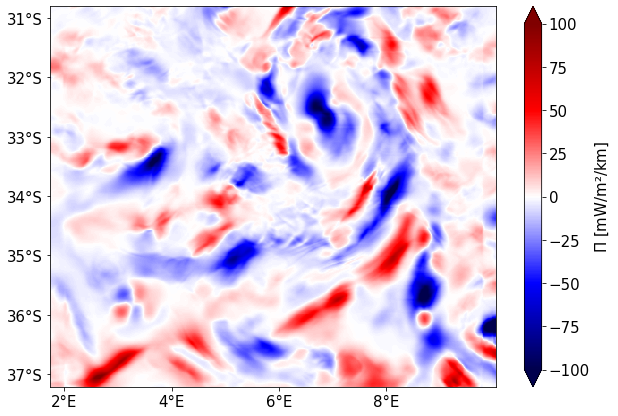

In [7]:
# show the scale kinetic energy flux in mW/m²/km
# note that the convolution is only valid for pixels that are not closer to the boundary than the radius of the top-hat kernel in pixel-cell size
plt.figure(figsize=(10,7))
cp = plt.pcolormesh(lon[radius:-radius],lat[radius:-radius],1e6*pi[radius:-radius],cmap='seismic',vmin=-100,vmax=100)
cbar = plt.colorbar(cp,shrink=1,extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\Pi$ [mW/m²/km]', fontsize = 15)
addplot()

Negative values show upscale fluxes from smaller to larger horizontal scales; positive downscale fluxes.
One can identify that in particular frontal regions 

### 2.2 Variant 2: On a Regular Kilometer-Grid
Although Variant 1 is faster in this example, it can get very memory demanding, in particular for large chosen length scales, and large regions.
You can speed it up the computations by first interpolating the velocity components onto a regular grid with a grid-spacing of e.g. 1 km. 
If you like to compute the flux for several length scales, this step needs to be done only once.

In [8]:
import numpy as np
import pyproj
from scipy import interpolate
from scipy.signal import convolve2d

In [9]:
%%time 
a = pyproj.Transformer.from_crs(4326,3395).transform(lon,lat) # project WGS84 onto metric grid
y3 = a[0]
x3 = a[1]
x3min = np.nanmin(x3,1)
y3min = np.nanmin(y3,0)
Y3min,X3min = np.meshgrid(y3min, x3min)
x1=(x3-X3min)/1000
y1=(y3-Y3min)/1000
x_len = int(np.floor(np.amax(x1))+1)
y_len = int(np.floor(np.amax(y1))+1)
x_dim = np.linspace(0, x_len, x_len, endpoint=False)
y_dim = np.linspace(0, y_len, y_len, endpoint=False)
x2, y2 = np.meshgrid(x_dim, y_dim)
ui = interpolate.griddata((x1.ravel(), y1.ravel()), np.array(u).ravel(), (x2, y2), method='linear')
vi = interpolate.griddata((x1.ravel(), y1.ravel()), np.array(v).ravel(), (x2, y2), method='linear')

CPU times: user 12.2 s, sys: 1.88 s, total: 14.1 s
Wall time: 11.4 s


In [10]:
%%time
# Now convolute the fields with a top-hat kernel, whichs diameter equals the chosen length scale.
r = scale/2.
r = int(r)
y,x = np.ogrid[-r: r+1, -r: r+1]
disk = x**2+y**2 <= r**2
disk = disk.astype(float)
disk = disk/sum(sum(disk))
um = convolve2d(ui,disk, mode='same', boundary='fill', fillvalue=0)
uum = convolve2d(ui**2,disk, mode='same', boundary='fill', fillvalue=0)
vm = convolve2d(vi,disk, mode='same', boundary='fill', fillvalue=0)
vvm = convolve2d(vi**2,disk, mode='same', boundary='fill', fillvalue=0)
uvm = convolve2d(ui*vi,disk, mode='same', boundary='fill', fillvalue=0)
# compute the horizontal derivatives of um and vm (using centred difference)
dumdx = (um[1:-1,2:]-um[1:-1,:-2])/2000
dumdy = (um[2:,1:-1]-um[:-2,1:-1])/2000
dvmdx = (vm[1:-1,2:]-vm[1:-1,:-2])/2000
dvmdy = (vm[2:,1:-1]-vm[:-2,1:-1])/2000
# compute the scale kinetic energy flux
rho_0 = 1024 # define standard density in kg/m³
pi2 = -1 * rho_0 * ((uum[1:-1,1:-1] - um[1:-1,1:-1] ** 2) * dumdx + (uvm[1:-1,1:-1] - um[1:-1,1:-1] * vm[1:-1,1:-1]) * (dumdy + dvmdy) + (vvm[1:-1,1:-1] - vm[1:-1,1:-1] ** 2) * dvmdy)    

CPU times: user 27.8 s, sys: 76.4 ms, total: 27.8 s
Wall time: 27.9 s


/gxfs_home/geomar/smomw244/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


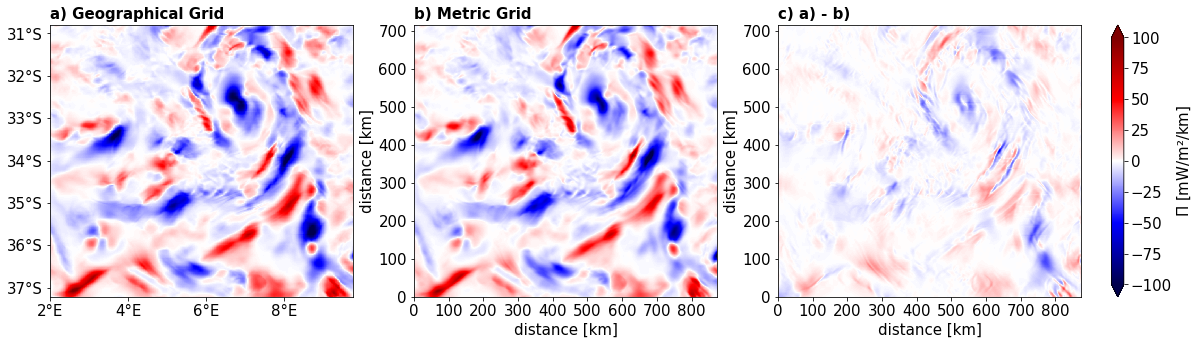

In [12]:
# show the scale kinetic energy flux in mW/m²/km
# note that the convolution is only valid for pixels that are not closer to the boundary than the radius of the top-hat kernel in pixel-cell size
plt.figure(figsize=(25,5))
gc=plt.GridSpec(1,4) # rows, columns
gc.update(wspace=0.2, hspace=0.1)

plt.subplot(gc[0,0])
cp = plt.pcolormesh(lon[radius:-radius,radius:-radius],lat[radius:-radius,radius:-radius],1e6*pi[radius:-radius,radius:-radius],cmap='seismic',vmin=-100,vmax=100)
addplot()
plt.title('a) Geographical Grid',fontsize=15,fontweight='bold',loc='left')

plt.subplot(gc[0,1])
cp = plt.pcolormesh(1e6*pi2[r:-r,r:-r],cmap='seismic',vmin=-100,vmax=100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('distance [km]',fontsize=15)
plt.ylabel('distance [km]',fontsize=15)
plt.title('b) Metric Grid',fontsize=15,fontweight='bold',loc='left')

plt.subplot(gc[0,2])
# interpolate the flux computed on the geographical grid onto the kilometer grid (to show the difference)
pi_i = interpolate.griddata((x1.ravel(), y1.ravel()), np.array(pi).ravel(), (x2, y2), method='linear')
cp = plt.pcolormesh(1e6*(pi_i[1:-1,1:-1]-pi2)[r:-r,r:-r],cmap='seismic',vmin=-100,vmax=100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('distance [km]',fontsize=15)
plt.ylabel('distance [km]',fontsize=15)
plt.title('c) a) - b)',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gc[0,-1])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,fraction=1.1,extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\Pi$ [mW/m²/km]', fontsize = 15)